# ROMY Status File

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import obspy as obs
import matplotlib.colors

from pandas import DataFrame, merge
from andbro__save_to_pickle import __save_to_pickle

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'
elif os.uname().nodename == 'lin-ffb-01':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'

In [3]:
from functions.load_beat import __load_beat
from functions.load_mlti import __load_mlti
from functions.get_mlti_intervals import __get_mlti_intervals

## Configurations

In [16]:
config = {}


config['tbeg'] = obs.UTCDateTime("2023-09-01")
config['tend'] = obs.UTCDateTime("2023-12-31")

config['ring'] = "U"

config['path_to_figures'] = archive_path+f"romy_plots/{config['tbeg'].year}/R{config['ring']}/status/"

config['path_to_data'] = archive_path+f"temp_archive/"


### Load Status Data

In [17]:
from functions.load_status import __load_status

In [18]:
statusU = __load_status(config['tbeg'], config['tend'], "U", config['path_to_data'])

 -> no such file: 2023/BW/RU/RU_2023-09-07_status.pkl
 -> no such file: 2023/BW/RU/RU_2023-09-27_status.pkl
 -> no such file: 2023/BW/RU/RU_2023-10-27_status.pkl
 -> no such file: 2023/BW/RU/RU_2023-10-28_status.pkl
 -> no such file: 2023/BW/RU/RU_2023-10-29_status.pkl
 -> no such file: 2023/BW/RU/RU_2023-10-30_status.pkl
 -> no such file: 2023/BW/RU/RU_2023-11-08_status.pkl
 -> no such file: 2023/BW/RU/RU_2023-11-09_status.pkl
 -> no such file: 2023/BW/RU/RU_2023-11-11_status.pkl
 -> no such file: 2023/BW/RU/RU_2023-11-18_status.pkl
 -> no such file: 2023/BW/RU/RU_2023-11-19_status.pkl
 -> no such file: 2023/BW/RU/RU_2023-11-29_status.pkl


In [19]:
statusU[statusU.times_utc > obs.UTCDateTime("2023-09-06 23:59")]

,times_utc,times_utc_sec,quality,fsagnac,mlti,ac_threshold,dc_threshold
2,2023-09-06T23:59:30.000000Z,518370.0,1.0,1.0,1.0,1.0,1.0
0,2023-09-07T00:00:30.000000Z,518430.0,NaN,NaN,NaN,NaN,NaN
1,2023-09-07T00:01:30.000000Z,518490.0,NaN,NaN,NaN,NaN,NaN
2,2023-09-07T00:02:30.000000Z,518550.0,NaN,NaN,NaN,NaN,NaN
3,2023-09-07T00:03:30.000000Z,518610.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
1438,2023-12-30T23:55:30.000000Z,10454130.0,0.0,0.0,1.0,1.0,1.0
1439,2023-12-30T23:56:30.000000Z,10454190.0,0.0,0.0,1.0,1.0,1.0
0,2023-12-30T23:57:30.000000Z,10454250.0,0.0,0.0,1.0,1.0,1.0
1,2023-12-30T23:58:30.000000Z,10454310.0,0.0,0.0,1.0,1.0,1.0


In [20]:
statusV = __load_status(config['tbeg'], config['tend'], "V", config['path_to_data'])

 -> no such file: 2023/BW/RV/RV_2023-09-07_status.pkl
 -> no such file: 2023/BW/RV/RV_2023-09-08_status.pkl
 -> no such file: 2023/BW/RV/RV_2023-09-09_status.pkl
 -> no such file: 2023/BW/RV/RV_2023-09-10_status.pkl
 -> no such file: 2023/BW/RV/RV_2023-09-17_status.pkl
 -> no such file: 2023/BW/RV/RV_2023-09-18_status.pkl
 -> no such file: 2023/BW/RV/RV_2023-09-19_status.pkl
 -> no such file: 2023/BW/RV/RV_2023-09-21_status.pkl
 -> no such file: 2023/BW/RV/RV_2023-09-25_status.pkl
 -> no such file: 2023/BW/RV/RV_2023-09-26_status.pkl
 -> no such file: 2023/BW/RV/RV_2023-09-27_status.pkl
 -> no such file: 2023/BW/RV/RV_2023-09-28_status.pkl
 -> no such file: 2023/BW/RV/RV_2023-09-29_status.pkl
 -> no such file: 2023/BW/RV/RV_2023-09-30_status.pkl
 -> no such file: 2023/BW/RV/RV_2023-10-01_status.pkl
 -> no such file: 2023/BW/RV/RV_2023-10-02_status.pkl
 -> no such file: 2023/BW/RV/RV_2023-10-03_status.pkl
 -> no such file: 2023/BW/RV/RV_2023-10-04_status.pkl
 -> no such file: 2023/BW/RV

In [21]:
statusZ = __load_status(config['tbeg'], config['tend'], "Z", config['path_to_data'])

 -> no such file: 2023/BW/RZ/RZ_2023-09-04_status.pkl
 -> no such file: 2023/BW/RZ/RZ_2023-09-05_status.pkl
 -> no such file: 2023/BW/RZ/RZ_2023-09-07_status.pkl
 -> no such file: 2023/BW/RZ/RZ_2023-09-10_status.pkl
 -> no such file: 2023/BW/RZ/RZ_2023-09-23_status.pkl
 -> no such file: 2023/BW/RZ/RZ_2023-09-24_status.pkl
 -> no such file: 2023/BW/RZ/RZ_2023-09-25_status.pkl
 -> no such file: 2023/BW/RZ/RZ_2023-09-28_status.pkl
 -> no such file: 2023/BW/RZ/RZ_2023-09-29_status.pkl
 -> no such file: 2023/BW/RZ/RZ_2023-10-03_status.pkl
 -> no such file: 2023/BW/RZ/RZ_2023-10-14_status.pkl
 -> no such file: 2023/BW/RZ/RZ_2023-10-15_status.pkl
 -> no such file: 2023/BW/RZ/RZ_2023-10-17_status.pkl
 -> no such file: 2023/BW/RZ/RZ_2023-10-18_status.pkl
 -> no such file: 2023/BW/RZ/RZ_2023-10-19_status.pkl
 -> no such file: 2023/BW/RZ/RZ_2023-10-20_status.pkl
 -> no such file: 2023/BW/RZ/RZ_2023-10-21_status.pkl
 -> no such file: 2023/BW/RZ/RZ_2023-10-22_status.pkl
 -> no such file: 2023/BW/RZ

### Define Variables

### Plotting

In [22]:
def __makelplot_single_status(df, ring):

    names = ["quality", "fsagnac", "mlti", "ac_threshold", "dc_threshold"]
    bars = np.ones(len(names))-0.5

    arr = np.ones((len(names), df['quality'].size))

    for _n, name in enumerate(names):
        arr[_n] *= df[name]

    time_scaling = 1

    cmap = matplotlib.colors.ListedColormap(['darkred', 'green'])

    font = 12

    fig, ax = plt.subplots(1, 1, figsize=(15, 4))

    c = ax.pcolormesh(df.times_utc_sec*time_scaling, names, arr, cmap=cmap, rasterized=True, alpha=0.8)

    for _k, bar in enumerate(bars):
        ax.axhline(bar+_k, color="w", alpha=0.8, lw=2)

    # ax.set_xlabel("Time (days)")

    ax.set_title(f"Quality Status of R{ring}")

    ref_date = df.times_utc.iloc[0]
    tcks = ax.get_xticks()
    tcklbls = [str((obs.UTCDateTime(ref_date)+t).date) for t in tcks]
    ax.set_xticklabels(tcklbls)

    ax.tick_params(axis='y', labelsize=font)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.show();
    return fig

/tmp/ipykernel_125466/2403924571.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(tcklbls)


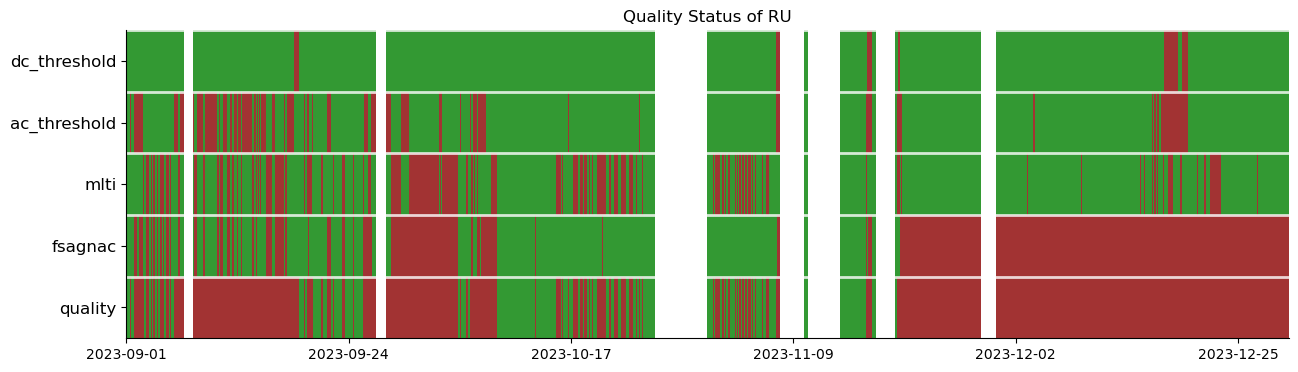

/tmp/ipykernel_125466/2403924571.py:19: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  c = ax.pcolormesh(df.times_utc_sec*time_scaling, names, arr, cmap=cmap, rasterized=True, alpha=0.8)


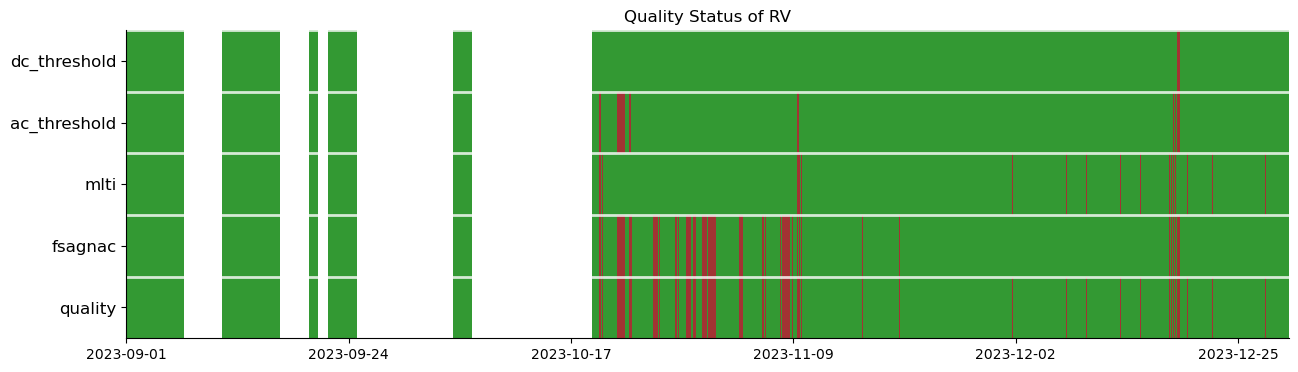

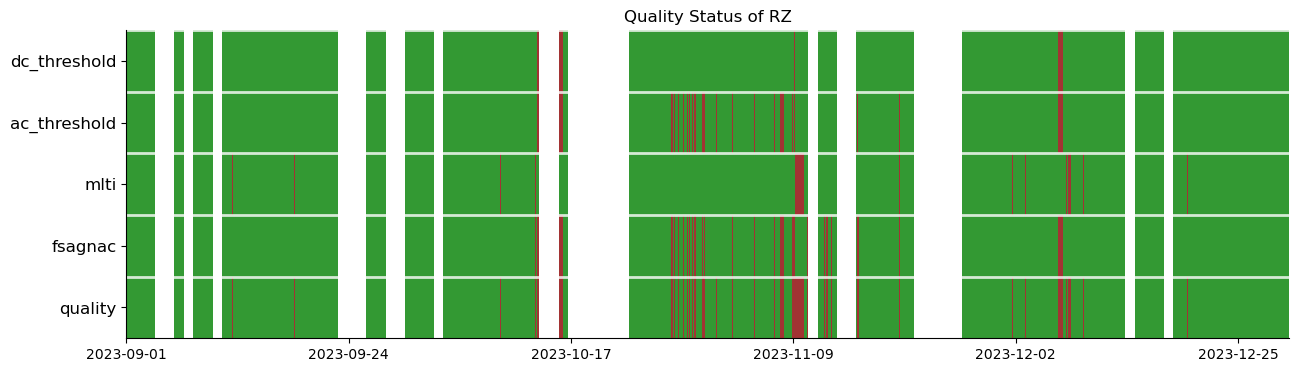

In [23]:
fig = __makelplot_single_status(statusU, "U")
fig = __makelplot_single_status(statusV, "V")
fig = __makelplot_single_status(statusZ, "Z")


# print(f" -> stored: {config['path_to_figures']}R{config['ring']}_{config['tbeg'].date}_status.png")
# fig.savefig(config['path_to_figures']+f"R{config['ring']}_{config['tbeg'].date}_status.png", format="png", dpi=100, bbox_inches='tight')

In [24]:
## create sub-frames
statusZ_mod = statusZ[['times_utc','quality']]
statusU_mod = statusU[['times_utc','quality']]
statusV_mod = statusV[['times_utc','quality']]

## remove NaN from times
statusZ_mod = statusZ_mod.dropna(subset="times_utc").reset_index()
statusV_mod = statusV_mod.dropna(subset="times_utc").reset_index()
statusU_mod = statusU_mod.dropna(subset="times_utc").reset_index()

# statusZ_mod.shape, statusU_mod.shape, statusV_mod.shape

## make times all to string objects
statusZ_mod['times_utc'] = statusZ_mod.times_utc.astype(str)
statusU_mod['times_utc'] = statusU_mod.times_utc.astype(str)
statusV_mod['times_utc'] = statusV_mod.times_utc.asty

((242870, 3), (235353, 3), (249087, 3))

In [26]:
## create new frame with all rings and their quality
df_new = statusZ_mod.copy()

df_new = df_new.merge(statusU_mod, how="outer", on=["times_utc"])
df_new = df_new.merge(statusV_mod, how="outer", on=["times_utc"])

## drop irrelevant columns
df_new.drop(columns=["index_x", "index_y", "index"], inplace=True)

## renaming ...
df_new.rename(columns={"quality_x":"RU", "quality_y":"RV", "quality":"RZ"}, inplace=True)

## add relative times
ref_time = df_new.times_utc.iloc[0]
df_new['times_utc_sec'] = np.array([abs(obs.UTCDateTime(ref_time) - obs.UTCDateTime(_t)) for _t in df_new.times_utc])

## add RW column
df_new['RW'] = np.ones(df_new.shape[0])*np.nan

## sort all by time
df_new.sort_values(by="times_utc", inplace=True)

/tmp/ipykernel_125466/2885634066.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(tcklbls)


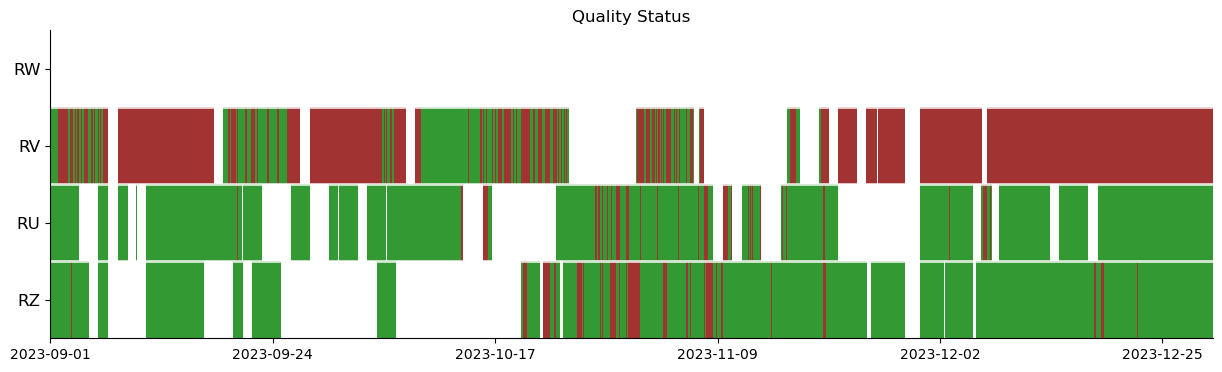

In [27]:
def __makelplot_all_status(df):

    bars = np.ones(4)-0.5

    arr = np.ones((4, df.shape[0]))

    names = ["RZ", "RU", "RV", "RW"]
    for _n, name in enumerate(names):
        arr[_n] *= df[name]

    time_scaling = 1

    cmap = matplotlib.colors.ListedColormap(['darkred', 'green'])

    font = 12

    fig, ax = plt.subplots(1, 1, figsize=(15, 4))

    c = ax.pcolormesh(df.times_utc_sec*time_scaling, names, arr, cmap=cmap, rasterized=True, alpha=0.8)

    for _k, bar in enumerate(bars):
        ax.axhline(bar+_k, color="w", alpha=0.8, lw=2)

    # ax.set_xlabel("Time (days)")

    ax.set_title(f"Quality Status")

    ref_date = df.times_utc.iloc[0]
    tcks = ax.get_xticks()
    tcklbls = [str((obs.UTCDateTime(ref_date)+t).date) for t in tcks]
    ax.set_xticklabels(tcklbls)

    ax.tick_params(axis='y', labelsize=font)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.show();
    return fig

fig = __makelplot_all_status(df_new);


0 RZ
1 RU
2 RV
3 RW


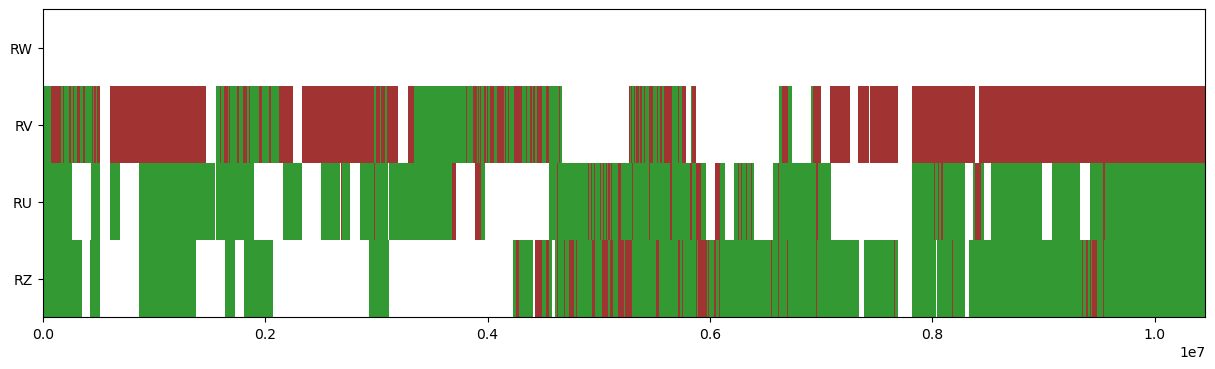

In [33]:
df = df_new

bars = np.ones(4)-0.5

arr = np.ones((4, df.shape[0]))

names = ["RZ", "RU", "RV", "RW"]
for _n, name in enumerate(names):
    print(_n, name)
    arr[_n] *= df[name]

time_scaling = 1

cmap = matplotlib.colors.ListedColormap(['darkred', 'green'])

font = 12

fig, ax = plt.subplots(1, 1, figsize=(15, 4))

c = ax.pcolormesh(df.times_utc_sec*time_scaling, names, arr, cmap=cmap, rasterized=True, alpha=0.8)
